# Midfield receiving analysis

How do top midfielders make leads to receive the ball and play forward?

Using Statsbomb 360 data, we can identify

- The position of a midfielder in the sequences of events leading to a receipt
- The receiving direction and velocity (?)
- The position of the nearest defenders and the distances from them to the midfielder
- The subsequent action made by the midfielder

We focus on specifically on the phase of play where the ball is facing the press, in possession. This is because it is highly repeatable and is usually the foundation of all buildup. 

We hypothesise that

- Receiving under low pressure is easy and players play more progressive options
- The leads made in the sequence up to the receipt creates the space to receive
- The leads that other players make in the sequence up to the receipt creates the space for the receiver
- The quality of the next action, including the success rate, speed and threat, is highly influenced by the angle, velocity and pitch position of the receipt

We want to explore

- What patterns are prevalent and whether certain teams have preferences for specific patterns


In [ ]:
from statsbombpy import sb
import pandas as pd
from mplsoccer import Pitch
import numpy as np

from utils.statsbomb_wrappers import Competitions, Match

In [16]:
import warnings

warnings.filterwarnings("ignore", module="statsbombpy")

In [71]:
competitions = Competitions()
competitions.competitions["competition_name"].unique()

array(['1. Bundesliga', 'African Cup of Nations', 'Champions League',
       'Copa America', 'Copa del Rey', "FA Women's Super League",
       'FIFA U20 World Cup', 'FIFA World Cup', 'Indian Super league',
       'La Liga', 'Liga Profesional', 'Ligue 1', 'Major League Soccer',
       'North American League', 'NWSL', 'Premier League', 'Serie A',
       'UEFA Euro', 'UEFA Europa League', "UEFA Women's Euro",
       "Women's World Cup"], dtype=object)

In [72]:
season = competitions.get_season("Women's World Cup", "2023")

/Users/gsheir/Documents/Statsbomb/tacticvis/venv/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/gsheir/Documents/Statsbomb/tacticvis/venv/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/gsheir/Documents/Statsbomb/tacticvis/venv/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/gsheir/Documents/Statsbomb/tacticvis/venv/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/gsheir/Documents/Statsbomb/tacticvis/venv/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/gsheir/Documents/Statsbomb/tactic

In [105]:
matches = season.get_matches()
matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3904629,2023-08-16,13:00:00.000,International - Women's World Cup,2023,Australia Women's,England Women's,1,3,available,...,2023-08-30T11:17:47.551826,6,Semi-finals,Accor Stadium,Tori Penso,Tony Gustavsson,Sarina Glotzbach-Wiegman,1.1.0,2,2
1,3906390,2023-08-20,13:00:00.000,International - Women's World Cup,2023,Spain Women's,England Women's,1,0,available,...,2023-08-22T19:38:43.965521,7,Final,Accor Stadium,Tori Penso,Jorge Vilda,Sarina Glotzbach-Wiegman,1.1.0,2,2
2,3906389,2023-08-19,11:00:00.000,International - Women's World Cup,2023,Sweden Women's,Australia Women's,2,0,available,...,2023-08-29T21:19:57.035390,7,3rd Place Final,Brisbane Stadium,Cheryl Foster,Peter Gerhardsson,Tony Gustavsson,1.1.0,2,2
3,3904628,2023-08-15,11:00:00.000,International - Women's World Cup,2023,Spain Women's,Sweden Women's,2,1,available,...,2023-08-16T11:30:31.556462,6,Semi-finals,Eden Park,Edina Alves Batista,Jorge Vilda,Peter Gerhardsson,1.1.0,2,2
4,3893806,2023-07-26,10:30:00.000,International - Women's World Cup,2023,Spain Women's,Zambia Women's,5,0,available,...,2023-08-15T02:58:57.266594,2,Group Stage,Eden Park,Hyeon-Jeong Oh,Jorge Vilda,Bruce Mwape,1.1.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,3893800,2023-07-24,09:00:00.000,International - Women's World Cup,2023,Italy Women's,Argentina Women's,1,0,available,...,2023-08-12T17:49:18.347307,1,Group Stage,Eden Park,Melissa Paola Borjas Pastrana,Milena Bertolini,Germán Darío Portanova,1.1.0,2,2
60,3893799,2023-07-24,11:30:00.000,International - Women's World Cup,2023,Germany Women's,Morocco Women's,6,0,available,...,2023-08-21T14:33:45.142288,1,Group Stage,AAMI Park,Tori Penso,Martina Voss-Tecklenburg,Reynald Pedros,1.1.0,2,2
61,3893796,2023-07-23,08:00:00.000,International - Women's World Cup,2023,Sweden Women's,South Africa Women's,2,1,available,...,2023-07-30T08:06:34.006738,1,Group Stage,Wellington Regional Stadium,Katja Koroleva,Peter Gerhardsson,Desiree Ellis,1.1.0,2,2
62,3893795,2023-07-22,15:00:00.000,International - Women's World Cup,2023,Denmark Women's,China PR Women's,1,0,available,...,2023-08-16T06:06:04.857484,1,Group Stage,HBF Park,Marie-Soleil Beaudoin,Lars Søndergaard,Qingxia Shui,1.1.0,2,2


First we focus on a specific match to explore.

In [106]:
match = Match(match_id=matches.iloc[0]["match_id"])
all_passes = match.get_events(type="Pass")

In [107]:
all_passes = all_passes[all_passes["team"] == "England Women's"]

Text(0.5, 1.0, 'All passes by England Women, n=511')

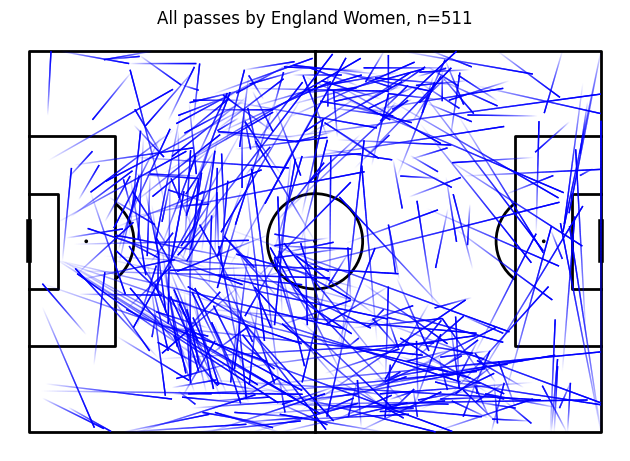

In [110]:
pitch = Pitch(pitch_color="#ffffff", line_color="#000000", line_zorder=2)
fig, ax = pitch.draw()

pass_arrows = pitch.lines(
    xstart=[loc[0] for loc in all_passes["location"].values],
    ystart=[loc[1] for loc in all_passes["location"].values],
    xend=[loc[0] for loc in all_passes["pass_end_location"].values],
    yend=[loc[1] for loc in all_passes["pass_end_location"].values],
    color="blue",
    ax=ax,
    lw=1,
    transparent=True,
)

ax.set_title("All passes by England Women, n={}".format(all_passes.shape[0]))

We limit passes to those that are

- Played from a defender to a midfielder


In [111]:
players = match.lineups["England Women's"]

In [112]:
defenders = []
midfielders = []

for index, player in players.iterrows():
    if len(player["positions"]) == 0:
        continue
    for position in player["positions"]:
        if position["position_id"] in [2, 3, 4, 5, 6, 7, 8]:
            defenders.append(player["player_name"])
        elif position["position_id"] in [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]:
            midfielders.append(player["player_name"])

print("Defenders: ", defenders)
print("Midfielders: ", midfielders)

Defenders:  ['Millie Bright', 'Rachel Daly', 'Lucy Bronze', 'Lucy Bronze', 'Alex Greenwood', 'Niamh Charles', 'Jessica Carter']
Midfielders:  ['Georgia Stanway', 'Georgia Stanway', 'Georgia Stanway', 'Keira Walsh', 'Keira Walsh', 'Keira Walsh', 'Ella Toone', 'Ella Toone']


In [113]:
all_passes = all_passes[
    all_passes["player"].isin(defenders)
    & all_passes["pass_recipient"].isin(midfielders)
]
all_passes.shape[0]

85

Text(0.5, 1.0, 'Passes from a defender to a midfielder, n=85')

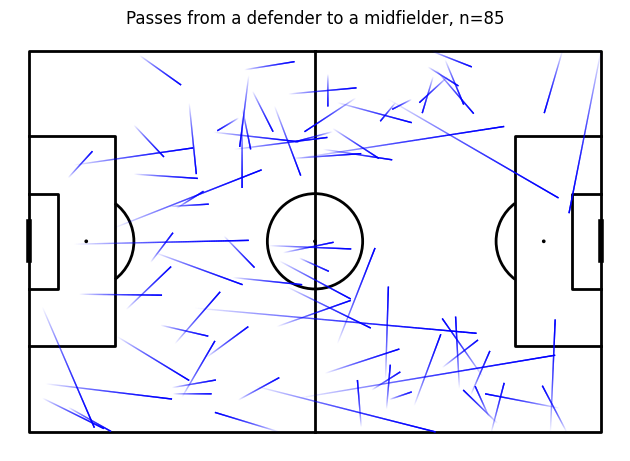

In [115]:
pitch = Pitch(pitch_color="#ffffff", line_color="#000000", line_zorder=2)
fig, ax = pitch.draw()

pass_arrows = pitch.lines(
    xstart=[loc[0] for loc in all_passes["location"].values],
    ystart=[loc[1] for loc in all_passes["location"].values],
    xend=[loc[0] for loc in all_passes["pass_end_location"].values],
    yend=[loc[1] for loc in all_passes["pass_end_location"].values],
    color="blue",
    ax=ax,
    lw=1,
    transparent=True,
)

ax.set_title("Passes from a defender to a midfielder, n={}".format(all_passes.shape[0]))

We further limit passes to those that break the first line. To visualise this, we use a couple of examples.

In [116]:
frames = sb.frames(
    match_id=matches.iloc[0]["match_id"],
)

In [117]:
pass_0 = all_passes.iloc[0]
frame_0 = frames[frames["id"] == pass_0["id"]]
frame_0

,id,visible_area,match_id,teammate,actor,keeper,location
71,7cb846aa-124a-401b-8148-98d911970fcd,"[19.3527547040363, 80.0, 43.5147202963666, 14....",3904629,True,True,False,"[34.79999923706055, 54.0]"
72,7cb846aa-124a-401b-8148-98d911970fcd,"[19.3527547040363, 80.0, 43.5147202963666, 14....",3904629,False,False,False,"[40.842879022654856, 49.37243284897751]"
73,7cb846aa-124a-401b-8148-98d911970fcd,"[19.3527547040363, 80.0, 43.5147202963666, 14....",3904629,True,False,False,"[41.41422502913011, 40.037473568727336]"
74,7cb846aa-124a-401b-8148-98d911970fcd,"[19.3527547040363, 80.0, 43.5147202963666, 14....",3904629,True,False,False,"[42.655517188027204, 65.59367150596785]"
75,7cb846aa-124a-401b-8148-98d911970fcd,"[19.3527547040363, 80.0, 43.5147202963666, 14....",3904629,True,False,False,"[49.51556197699786, 47.89908009650114]"
76,7cb846aa-124a-401b-8148-98d911970fcd,"[19.3527547040363, 80.0, 43.5147202963666, 14....",3904629,False,False,False,"[50.14428331635497, 60.224380402596346]"
77,7cb846aa-124a-401b-8148-98d911970fcd,"[19.3527547040363, 80.0, 43.5147202963666, 14....",3904629,True,False,False,"[52.34877464220287, 31.397912824902384]"
78,7cb846aa-124a-401b-8148-98d911970fcd,"[19.3527547040363, 80.0, 43.5147202963666, 14....",3904629,True,False,False,"[62.17666649833769, 59.21919358330636]"


Text(0.5, 1.0, 'Pass from Millie Bright to Ella Toone')

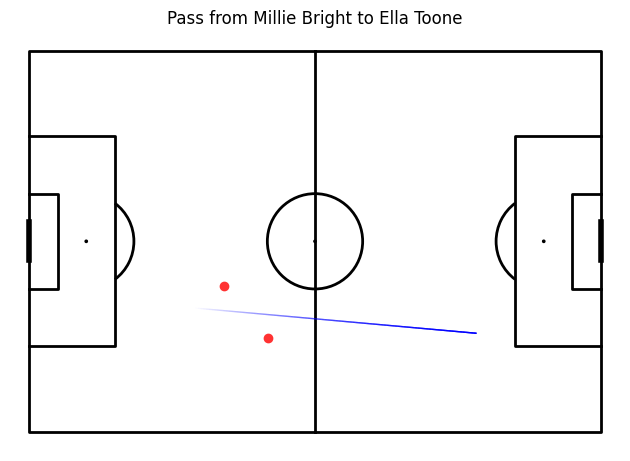

In [118]:
pitch = Pitch(pitch_color="#ffffff", line_color="#000000", line_zorder=2)
fig, ax = pitch.draw()

pass_arrows = pitch.lines(
    xstart=[pass_0["location"][0]],
    ystart=[pass_0["location"][1]],
    xend=[pass_0["pass_end_location"][0]],
    yend=[pass_0["pass_end_location"][1]],
    color="blue",
    ax=ax,
    lw=1,
    transparent=True,
)

opponents = pitch.scatter(
    x=[x for (x, y) in frame_0["location"].loc[frame_0["teammate"] == False]],
    y=[y for (x, y) in frame_0["location"].loc[frame_0["teammate"] == False]],
    c="red",
    ax=ax,
)

visible_area = pitch.polygon(
    verts=[np.array(frame_0["visible_area"].iloc[0]).reshape((5, 2))],
    color="white",
    alpha=0.2,
    ax=ax,
)

ax.set_title(
    f"Pass from {pass_0['player']} to {pass_0['pass_recipient']}".format(
        all_passes.shape[0]
    )
)

Some comments on this visualisation:

- We see that it breaks a line, but we don't know which line, and we don't know where the other defenders are due to the limited visible area. We might need to look forward and backwards in time to gain context. 
- We need to find a way of calculating whether the line is broken. We could say that
  - The pass has to pass between two opposition players
  - The pass has to be predominantly forwards?
  - The defensive line has to be predominantly horizontal? How do we calculate the horizontal-ness of a defensive line? Does a W-shape first line count if all the individual lines are <45 degrees to the vertical?
  - What happens to passes between an opposition player and the sideline?